# 循环神经网路的简洁实现

In [68]:
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

In [69]:
batch_size, num_steps = 32, 35

In [70]:
train_iter, vocab = d2l.load_data_time_machine(batch_size=batch_size, num_steps=num_steps)

In [71]:
len(vocab)

28

## 定义模型

In [72]:
num_hiddens = 256
rnn_layer = nn.RNN(len(vocab), num_hiddens)
for weight in rnn_layer.all_weights[0]:
    print(weight.shape)

torch.Size([256, 28])
torch.Size([256, 256])
torch.Size([256])
torch.Size([256])


In [73]:
state = torch.zeros((1, batch_size, num_hiddens))
state.shape

torch.Size([1, 32, 256])

In [74]:
X = torch.rand(size=(num_steps, batch_size, len(vocab)))
Y, state_new = rnn_layer(X, state)
Y.shape, state_new.shape

(torch.Size([35, 32, 256]), torch.Size([1, 32, 256]))

In [75]:
#@save
class RNNModel(nn.Module):
    def __init__(self, rnn_layer, vocab_size, **kwargs):
        super(RNNModel, self).__init__(**kwargs)
        self.rnn = rnn_layer
        self.vocab_size = vocab_size
        self.num_hiddens = self.rnn.hidden_size
        if not self.rnn.bidirectional:
            self.num_directions = 1
            self.linear = nn.Linear(self.num_hiddens, self.vocab_size)
        else:
            self.num_directions = 2
            self.linear = nn.Linear(self.num_hiddens * 2, self.vocab_size)
            
    def forward(self, inputs, state):
        X = F.one_hot(inputs.T.long(), self.vocab_size)
        X = X.to(torch.float32)
        Y, state = self.rnn(X, state)
        output = self.linear(Y.reshape((-1, Y.shape[-1])))
        return output, state
    
    def begin_state(self, device, batch_size=1):
        if not isinstance(self.rnn, nn.LSTM):
            return torch.zeros((self.num_directions * self.rnn.num_layers, batch_size, self.num_hiddens), device=device)
        else:
            return (torch.zeros((self.num_directions * self.rnn.num_layers, batch_size, self.num_hiddens), device=device), \
                    torch.zeros((self.num_directions * self.rnn.num_layers, batch_size, self.num_hiddens), device=device))

## 训练和预测

### equation
$h_t = \tanh(x_t W_{ih}^T + b_{ih} + h_{t-1}W_{hh}^T + b_{hh})$

In [76]:
device = d2l.try_gpu()
net = RNNModel(rnn_layer, vocab_size=len(vocab))
net = net.to(device)
d2l.predict_ch8('time traveller', 10, net, vocab, device)

'time travellerffffffffff'

perplexity 1.7, 276939.5 tokens/sec on cuda:0
time traveller his saver were thing to erythes thepredithes inca
travellersal thalndree tiris sime saided for mais tomes it 


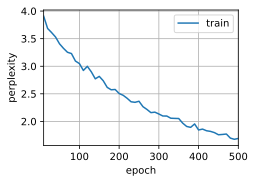

In [84]:
num_epochs, lr = 500, 0.1
d2l.train_ch8(net, train_iter, vocab, lr, num_epochs, device)

In [91]:
dic = net.state_dict()
for key in dic.keys():
    print(f'{key}:{dic.get(key).shape}')

rnn.weight_ih_l0:torch.Size([256, 28])
rnn.weight_hh_l0:torch.Size([256, 256])
rnn.bias_ih_l0:torch.Size([256])
rnn.bias_hh_l0:torch.Size([256])
linear.weight:torch.Size([28, 256])
linear.bias:torch.Size([28])


## 测试

In [78]:
rnn = nn.RNN(input_size=10,hidden_size=20,num_layers=2) # 输入大小10,隐藏数20,层数2
input = torch.randn(5,3,10) # sequence length = 5, batch size = 3
h0 = torch.randn(2,3,20) # 层数=2, batch size=3, 隐藏数=20 
output, hn = rnn(input, h0) 

In [79]:
input.shape

torch.Size([5, 3, 10])

In [80]:
input.transpose(0,1).shape

torch.Size([3, 5, 10])

In [81]:
for weight in rnn.all_weights[0]:
    print(weight.shape)

torch.Size([20, 10])
torch.Size([20, 20])
torch.Size([20])
torch.Size([20])


In [82]:
h_t_minus_1 = h_t = h_0 = torch.zeros(2, 3, 20)
output = []
for t in range(5): # 序列
    for layer in range(2): # 层数
        h_t[layer] = torch.tanh(
            input[t] @ rnn.all_weights[0][0].T
            + rnn.all_weights[0][2]
            + h_t_minus_1[layer] @ rnn.all_weights[0][1].T
            + rnn.all_weights[0][3]
        )
    # [3,10] @ [10,20] + [20] + [3,20] @ [20, 20] + [20] = [3,20]
    output.append(h_t[-1])
    h_t_minus_1 = h_t
output = torch.stack(output)
output.shape, h_t.shape

(torch.Size([5, 3, 20]), torch.Size([2, 3, 20]))

$W_{ih}$:torch.Size([20, 10])
$W_{hh}$:torch.Size([20, 20])
偏置$bias_{ih}$:torch.Size([20])
偏置$bias_{hh}$:torch.Size([20])

In [83]:
a = torch.randn(3, 10) #inputs每一个序列的数据size
b = torch.randn(10, ) 
(a @ b).shape

torch.Size([3])

## 分析detach()

In [127]:
x = torch.randn(2,3)
x.requires_grad=True

In [128]:
y=x.detach()
# y.requires_grad=True
x,y

(tensor([[ 0.4194,  1.3066, -1.1255],
         [-0.4683,  1.1643,  0.6454]], requires_grad=True),
 tensor([[ 0.4194,  1.3066, -1.1255],
         [-0.4683,  1.1643,  0.6454]]))

`tensor.detach()`:返回一个新的tensor，从当前计算图中分离下来的，但是仍指向原变量的存放位置,不同之处只是requires_grad为false，得到的这个tensor永远不需要计算其梯度，不具有grad。

In [123]:
x.requires_grad, y.requires_grad

(True, True)

In [124]:
y = y * 2
x,y

(tensor([[-0.6646, -0.1700, -0.3358],
         [-0.7676, -0.0066,  0.3936]], requires_grad=True),
 tensor([[-1.3293, -0.3399, -0.6715],
         [-1.5352, -0.0132,  0.7872]], grad_fn=<MulBackward0>))

In [125]:
z = x.detach_()
x.requires_grad, z.requires_grad

(False, False)